In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# For date calculations
from datetime import datetime

In [10]:
df = pd.read_excel('/content/online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [11]:
#Quick EDA
print(df.shape)
print(df.isnull().sum())
print(df.describe())

(525461, 8)
Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64
            Quantity                    InvoiceDate          Price  \
count  525461.000000                         525461  525461.000000   
mean       10.337667  2010-06-28 11:37:36.845017856       4.688834   
min     -9600.000000            2009-12-01 07:45:00  -53594.360000   
25%         1.000000            2010-03-21 12:20:00       1.250000   
50%         3.000000            2010-07-06 09:51:00       2.100000   
75%        10.000000            2010-10-15 12:45:00       4.210000   
max     19152.000000            2010-12-09 20:01:00   25111.090000   
std       107.424110                            NaN     146.126914   

         Customer ID  
count  417534.000000  
mean    15360.645478  
min     12346.000000  
25%     13983.000000  
50%     15311.000000  
75%     16799.000000  
max    

In [12]:
#Data Cleaning
# Remove rows with missing CustomerID

df = df[df['Customer ID'].notna()]

# Remove returns (negative quantities) and zero prices
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [13]:
#Create RFM features
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days = 1)

# Group by CustomerID
rfm = df.groupby('Customer ID').agg({

          'InvoiceDate':lambda x:(snapshot_date - x.max()).days, # Recency
          'Invoice' : 'nunique', # Frequency
          'TotalPrice' : 'sum'   # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93


In [14]:
#Explore RFM

rfm[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,4312.000000,4312.000000,4312.000000
mean,91.171846,4.455705,2048.238236
std,96.860633,8.170213,8914.481280
min,1.000000,1.000000,2.950000
25%,18.000000,1.000000,307.987500
50%,53.000000,2.000000,706.020000
75%,136.000000,5.000000,1723.142500
max,374.000000,205.000000,349164.350000


In [15]:
#Handle skewness with log transform
# Apply log transform on Frequency & Monetary

rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

rfm[['Frequency_log', 'Monetary_log']].describe()

,Frequency_log,Monetary_log
count,4312.000000,4312.000000
mean,1.371142,6.615798
std,0.690565,1.279844
min,0.693147,1.373716
25%,0.693147,5.733301
50%,1.098612,6.561059
75%,1.791759,7.452485
max,5.327876,12.763301


In [16]:
#Scaling features
# Select features for clustering
features = ['Recency', 'Frequency_log', 'Monetary_log']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[features])

X_scaled[:5]

array([[ 0.76229851,  1.61301719, -0.54068849],
       [-0.91040156, -0.39469275,  0.44765077],
       [-0.17730462, -0.98191026, -0.94390356],
       [-0.4973892 ,  0.02194471,  0.99620368],
       [-0.82779909, -0.98191026, -0.70767059]])

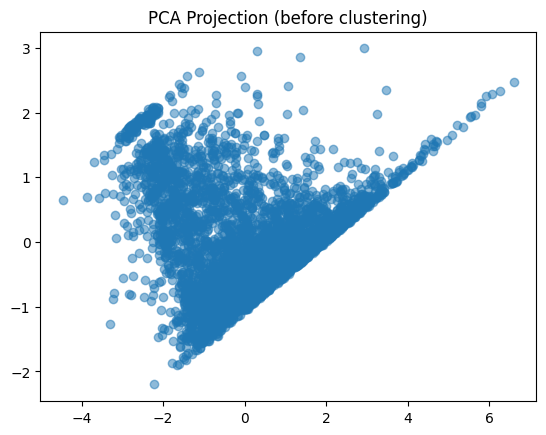

In [17]:
#PCA for visualization

pca = PCA(n_components = 2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha = 0.5)
plt.title("PCA Projection (before clustering)")
plt.show()

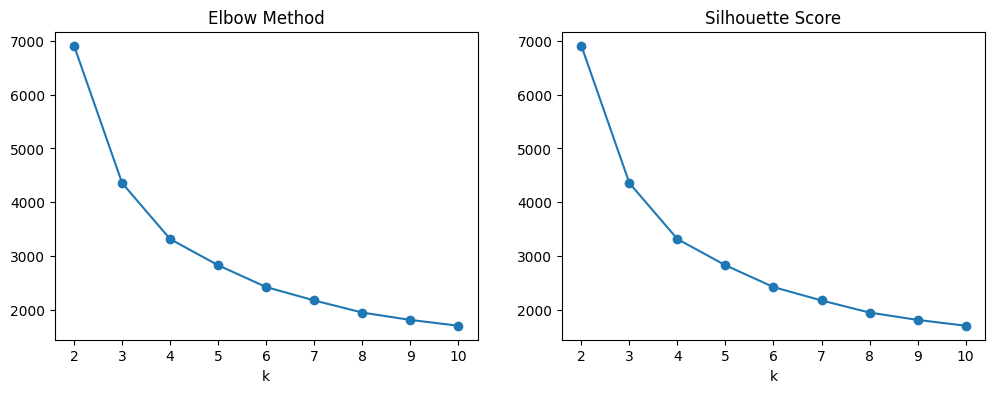

In [23]:
#Elbow & Silhouette method
inertia = []
sil_scores = []
k_range = range(2,11)

for k in k_range:
  km = KMeans(n_clusters = k, random_state = 42, n_init = 10)
  km.fit(X_scaled)
  inertia.append(km.inertia_)
  sil_scores.append(silhouette_score(X_scaled,km.labels_))

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(k_range, inertia, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('k')

plt.subplot(1,2,2)
plt.plot(k_range, inertia, marker = 'o')
plt.title('Silhouette Score')
plt.xlabel('k')

plt.show()

In [24]:
#Fit final model
# Choose k based on elbow/silhouette (example: k=4)

k = 4
kmeans = KMeans(n_clusters = k, random_state = 42, n_init=50)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Frequency_log,Monetary_log,Cluster
0,12346.0,165,11,372.86,2.484907,5.923881,3
1,12347.0,3,2,1323.32,1.098612,7.188654,3
2,12348.0,74,1,222.16,0.693147,5.407889,0
3,12349.0,43,3,2671.14,1.386294,7.890635,3
4,12351.0,11,1,300.93,0.693147,5.710195,0


In [27]:
#Cluster profiling
profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency_log': 'mean',
    'Monetary_log': 'mean',
    'Customer ID': 'count'
}).rename(columns = {'Customer ID':'Count'}).reset_index()


profile


,Cluster,Recency,Frequency_log,Monetary_log,Count
0,0,56.686486,0.879421,5.715207,1295
1,1,23.163522,2.599728,8.544088,636
2,2,255.269401,0.842444,5.609683,902
3,3,50.533469,1.595809,7.188745,1479


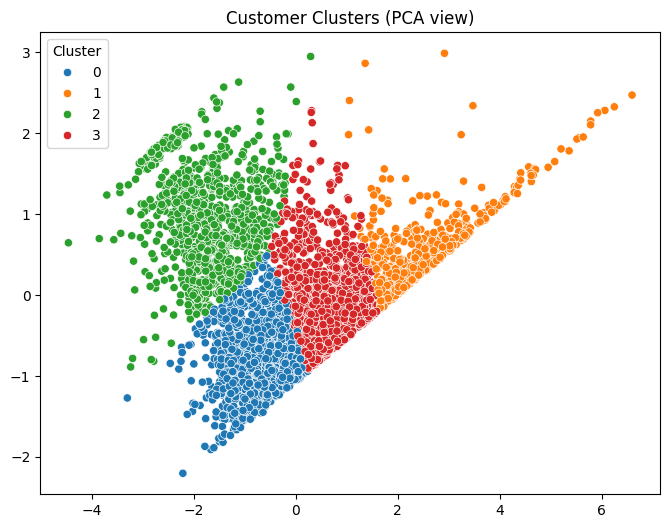

In [28]:
#Visualize clusters in PCA space
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=rfm['Cluster'], palette='tab10')
plt.title("Customer Clusters (PCA view)")
plt.show()